In [1]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import os
import random
import time
import pickle
import datetime
import siren
from siren import SIREN
from PIL import Image
from coordx import coordx_net
from helpers import psnr

In [30]:
MODEL_DIR = "models\\"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Regular no sample training 
def train(model, optimizer:torch.optim, dims:list[torch.tensor], target:torch.tensor, n_epochs:int, print_step:int=1000):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    '''
    target = target.to(device)
    loss_fn = torch.nn.MSELoss()
    torch.backends.cudnn.benchmark = False
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(n_epochs+1):
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None  
        with torch.cuda.amp.autocast():
            out = model(dims)        
            loss = loss_fn(out, target)
        #loss.backward()
        scaler.scale(loss).backward()
        #optimizer.step()
        scaler.step(optimizer)
        
        scaler.update()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

In [4]:
# Regular no sample training 
def train_noscaler(model, optimizer:torch.optim, dims:list[torch.tensor], target:torch.tensor, n_epochs:int, print_step:int=1000):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    '''
    target = target.to(device)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(n_epochs+1):
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
        
        out = model(dims)        
        loss = loss_fn(out, target)
        loss.backward()
        
        optimizer.step()
        
        

        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

In [6]:
# training with 
def accelerated_train(model, optimizer:torch.optim, dims:list[torch.Tensor], target:torch.tensor, n_epochs:int, print_step:int=1000, n_samples:int=262144):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    @param n_samples: the (rough) number of pixels to sample
    '''
    y_coords = target.shape[1]
    x_coords = target.shape[2]

    v = y_coords*x_coords 
    mu = (n_samples/v)**(1/2)
    target = target.to(device)

    x_dist = torch.ones(x_coords, device=device)/x_coords
    y_dist = torch.ones(y_coords, device=device)/y_coords
    
    loss_fn = torch.nn.MSELoss()

    torch.backends.cudnn.benchmark = False
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(n_epochs+1):
        # Sampling 
        # add a bit of noise 
        mu_noisy = min(random.normalvariate(mu=mu,sigma=0.01),1)

        # use torch multinomial to select coordinates for each dim
        num_samples = int(mu_noisy*x_coords)
        x_samples = x_dist.multinomial(num_samples).sort().values
        #x_in = dims[0].index_select(0, x_samples)

        num_samples = int(mu_noisy*y_coords)
        y_samples = y_dist.multinomial(num_samples).sort().values
        #y_in = dims[1].index_select(0, y_samples)

        # use torch index_select for grabbing the index of each dim
        sampled_target = target.index_select(1, y_samples).index_select(2, x_samples)

        # Training 
    
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None  
        with torch.cuda.amp.autocast():
            out = model([dims[0].index_select(0, x_samples), dims[1].index_select(0, y_samples)])     
            loss = loss_fn(out, sampled_target)
        #loss.backward()
        scaler.scale(loss).backward()
        #optimizer.step()
        scaler.step(optimizer)
        
        scaler.update()
        
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

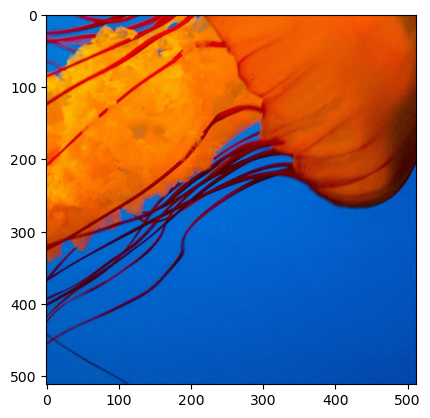

In [18]:
# load a random div2k image
#random.randint(1, 801)
n = str(48).zfill(4)
img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(512),    
    torchvision.transforms.ToTensor()
])
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))

In [19]:
y_coords = img.shape[1]
x_coords = img.shape[2]

x = torch.linspace(1, x_coords, x_coords).reshape(-1,1).to(device)
y = torch.linspace(1, y_coords, y_coords).reshape(-1,1).to(device)

In [9]:
#training with sampling
sample_factor = 10
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=500, print_step=500, n_samples=int((512*512)/sample_factor))
final = model([x,y])
print(f'PSNR: {psnr(img, final.cpu())}')

Iteration: 0 | Loss: 0.1541474461555481
Iteration: 500 | Loss: 0.029224488884210587
PSNR: 15.707030296325684


In [22]:
# training without sampling without autocast

model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
train_time = time.time()
train_noscaler(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500)
train_time = time.time() - train_time
final = model([x,y])
print(f'PSNR: {psnr(img, final.cpu())} time: {train_time}')

Iteration: 0 | Loss: 0.14930614829063416
Iteration: 500 | Loss: 0.014345839619636536
Iteration: 1000 | Loss: 0.008719578385353088
Iteration: 1500 | Loss: 0.005676093511283398
Iteration: 2000 | Loss: 0.003409814788028598
Iteration: 2500 | Loss: 0.0021553041879087687
Iteration: 3000 | Loss: 0.0014471649192273617
Iteration: 3500 | Loss: 0.001025718287564814
Iteration: 4000 | Loss: 0.0007630485924892128
Iteration: 4500 | Loss: 0.0005890122847631574
Iteration: 5000 | Loss: 0.00046924559865146875
Iteration: 5500 | Loss: 0.00038505991687998176
Iteration: 6000 | Loss: 0.00032420476782135665
Iteration: 6500 | Loss: 0.0002785972028505057
Iteration: 7000 | Loss: 0.0002442840486764908
Iteration: 7500 | Loss: 0.00021833920618519187
Iteration: 8000 | Loss: 0.0001973920443560928
Iteration: 8500 | Loss: 0.0001807850640034303
Iteration: 9000 | Loss: 0.00016743061132729053
Iteration: 9500 | Loss: 0.00015838620311114937
Iteration: 10000 | Loss: 0.00014813196321483701
Iteration: 10500 | Loss: 0.0001400652

In [76]:
# training without sampling with autocast
torch.backends.cudnn.benchmark = False
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
train_time = time.time()
train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500)
train_time = time.time() - train_time
final = model([x,y])
print(f'PSNR: {psnr(img, final.cpu())} time: {train_time}')

Iteration: 0 | Loss: 0.14875751733779907
Iteration: 500 | Loss: 0.0017924964195117354
Iteration: 1000 | Loss: 0.0008418066427111626
Iteration: 1500 | Loss: 0.0006433483795262873
Iteration: 2000 | Loss: 0.0004959095967933536
Iteration: 2500 | Loss: 0.00041059026261791587
Iteration: 3000 | Loss: 0.0003478064318187535
Iteration: 3500 | Loss: 0.000322457286529243
Iteration: 4000 | Loss: 0.00029082148103043437
Iteration: 4500 | Loss: 0.00028359261341392994
Iteration: 5000 | Loss: 0.00025694735813885927
Iteration: 5500 | Loss: 0.00026360322954133153
Iteration: 6000 | Loss: 0.00022633506159763783
Iteration: 6500 | Loss: 0.00021489884238690138
Iteration: 7000 | Loss: 0.00019992793386336416
Iteration: 7500 | Loss: 0.00021884548186790198
Iteration: 8000 | Loss: 0.0001919724454637617
Iteration: 8500 | Loss: 0.0001953643950400874
Iteration: 9000 | Loss: 0.00018033564265351743
Iteration: 9500 | Loss: 0.0001898585760500282
Iteration: 10000 | Loss: 0.00018744776025414467
Iteration: 10500 | Loss: 0.00

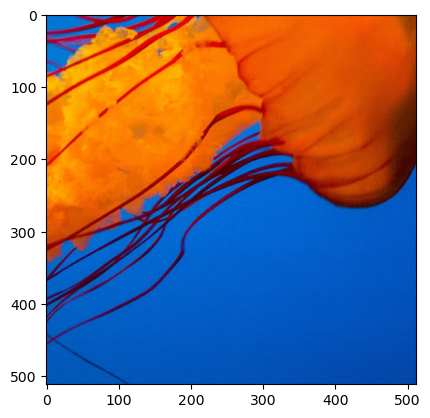

In [77]:
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()

In [87]:
# training with sampling and autocast

model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
train_time = time.time()
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=int((512*512)/10))
train_time = time.time() - train_time
final = model([x,y])
print(f'PSNR: {psnr(img, final.cpu())} time: {train_time}')

Iteration: 0 | Loss: 0.15236306190490723
Iteration: 500 | Loss: 0.004531145561486483
Iteration: 1000 | Loss: 0.0015991691034287214
Iteration: 1500 | Loss: 0.0010298597626388073
Iteration: 2000 | Loss: 0.0008459188393317163
Iteration: 2500 | Loss: 0.0006399955018423498
Iteration: 3000 | Loss: 0.000604647328145802
Iteration: 3500 | Loss: 0.0005283929058350623
Iteration: 4000 | Loss: 0.00043024527258239686
Iteration: 4500 | Loss: 0.0004543630057014525
Iteration: 5000 | Loss: 0.00038431223947554827
Iteration: 5500 | Loss: 0.00035369122633710504
Iteration: 6000 | Loss: 0.000330373557517305
Iteration: 6500 | Loss: 0.0003692172758746892
Iteration: 7000 | Loss: 0.0003041776071768254
Iteration: 7500 | Loss: 0.0003161285421811044
Iteration: 8000 | Loss: 0.0002790513972286135
Iteration: 8500 | Loss: 0.0003000920114573091
Iteration: 9000 | Loss: 0.000262437853962183
Iteration: 9500 | Loss: 0.00025610870216041803
Iteration: 10000 | Loss: 0.000244221359025687
Iteration: 10500 | Loss: 0.0002409355947

In [10]:
# Try saving model

torch.save(model.state_dict(), MODEL_DIR+"test.pth")

In [14]:
# Loading the model
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
model.load_state_dict(torch.load(MODEL_DIR+"test.pth"))
model.eval()

final = model([x,y])
print(f'PSNR: {psnr(img, final.cpu())}')

PSNR: 16.648027420043945


In [38]:
# Putting it together to test model training on 12 images
sample_factor = 10 # divide total number of pixels by sample factor
n_epochs = 20000

image_numbers = random.sample(range(1,801), 12)
images_trained = dict.fromkeys(image_numbers, {})
for i,image_num in enumerate(image_numbers):
    print(f"Training Image {image_num}, image {i+1}/12")
    # Get the image
    n = str(image_num).zfill(4)
    img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(512),    
        torchvision.transforms.ToTensor()
    ])
    img = transforms(img)

    # Test training the image without sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=500)
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['no_sampling_psnr'] = psnr_score
    images_trained[image_num]['no_sampling_time'] = train_time
    images_trained[image_num]['n_epochs'] = n_epochs
    print(f'PSNR: {psnr_score} time: {train_time}')

    # Save the model
    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_no_sampling.pth")

    #training with sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=500, n_samples=int((512*512)/sample_factor))
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['sampled_psnr'] = psnr_score
    images_trained[image_num]['sampled_time'] = train_time
    print(f'PSNR: {psnr_score} time: {train_time}')

    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_test_sampled.pth")


Training Image 383, image 1/12
Iteration: 0 | Loss: 0.09370484203100204
Iteration: 500 | Loss: 0.0059484196826815605
Iteration: 1000 | Loss: 0.002657907782122493
Iteration: 1500 | Loss: 0.0017838578205555677
Iteration: 2000 | Loss: 0.0013521149521693587
Iteration: 2500 | Loss: 0.0010353304678574204
Iteration: 3000 | Loss: 0.0007871616980992258
Iteration: 3500 | Loss: 0.0006063503678888083
Iteration: 4000 | Loss: 0.00047793611884117126
Iteration: 4500 | Loss: 0.0003828570188488811
Iteration: 5000 | Loss: 0.00031291082268580794
Iteration: 5500 | Loss: 0.0002609381335787475
Iteration: 6000 | Loss: 0.00022090644051786512
Iteration: 6500 | Loss: 0.00019008610979653895
Iteration: 7000 | Loss: 0.00016773927200119942
Iteration: 7500 | Loss: 0.0001467934635002166
Iteration: 8000 | Loss: 0.000133653316879645
Iteration: 8500 | Loss: 0.00011904679558938369
Iteration: 9000 | Loss: 0.00010848027159227058
Iteration: 9500 | Loss: 9.866039908956736e-05
Iteration: 10000 | Loss: 9.039837459567934e-05
Ite

In [39]:
images_trained


{383: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 463: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 384: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 49: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 421: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 206: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.939551353

In [58]:
file = open('test_data_R2.pkl', 'wb')
pickle.dump(images_trained, file)
file.close()

In [8]:
file = open('test_data.pkl', 'rb')
data = pickle.load(file)
file.close()

In [9]:
data

{383: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 463: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 384: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 49: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 421: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.9395513534546,
  'n_epochs': 20000,
  'sampled_psnr': 34.51251983642578,
  'sampled_time': 61.716023683547974},
 206: {'no_sampling_psnr': 38.44548797607422,
  'no_sampling_time': 201.939551353

In [43]:
total_sampling_time = 0
total_nonsampled_time = 0
num_images = 0
sum_sampled_psnr = 0
sum_nonsampled_psnr = 0
for pic in data:
    num_images += 1
    total_sampling_time += data[pic]['sampled_time']
    total_nonsampled_time += data[pic]['no_sampling_time']
    sum_sampled_psnr += data[pic]['sampled_psnr']
    sum_nonsampled_psnr += data[pic]['no_sampling_psnr']
print(f"Training time, non sampled: {total_nonsampled_time/60.0:.2f}")
print(f"Training time, sampled: {total_sampling_time/60.0:.2f}")
print(f"Average PSNR, non sampled: {sum_nonsampled_psnr/num_images:.2f}")
print(f"Average PSNR, sampled: {sum_sampled_psnr/num_images:.2f}")

In [55]:
print(f"Training time, non sampled: {total_nonsampled_time/60.0:.2f}")
print(f"Training time, sampled: {total_sampling_time/60.0:.2f}")
print(f"Average PSNR, non sampled: {sum_nonsampled_psnr/num_images:.2f}")
print(f"Average PSNR, sampled: {sum_sampled_psnr/num_images:.2f}")

Training time, non sampled: 40.39
Training time, sampled: 12.34
Average PSNR, non sampled: 38.45
Average PSNR, sampled: 34.51


In [56]:
40.39/12.34

3.273095623987034

In [57]:
22.33/5.73

3.897033158813263

In [10]:
image_nums = list(data.keys())
image_nums

[383, 463, 384, 49, 421, 206, 229, 420, 583, 270, 553, 181]

In [60]:
# Try again with r = 1
sample_factor = 10 # divide total number of pixels by sample factor
n_epochs = 20000

image_numbers = image_nums # use previous image numbers
images_trained = dict.fromkeys(image_numbers, {})
for i,image_num in enumerate(image_numbers):
    print(f"Training Image {image_num}, image {i+1}/12")
    # Get the image
    n = str(image_num).zfill(4)
    img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(512),    
        torchvision.transforms.ToTensor()
    ])
    img = transforms(img)

    # Test training the image without sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=500)
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['no_sampling_psnr'] = psnr_score
    images_trained[image_num]['no_sampling_time'] = train_time
    images_trained[image_num]['n_epochs'] = n_epochs
    print(f'PSNR: {psnr_score} time: {train_time}')

    # Save the model
    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_R1_no_sampling_.pth")

    #training with sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=500, n_samples=int((512*512)/sample_factor))
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['sampled_psnr'] = psnr_score
    images_trained[image_num]['sampled_time'] = train_time
    print(f'PSNR: {psnr_score} time: {train_time}')

    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_R1_test_sampled.pth")


Training Image 383, image 1/12
Iteration: 0 | Loss: 0.07444235682487488
Iteration: 500 | Loss: 0.0072098420932888985
Iteration: 1000 | Loss: 0.0030026640743017197
Iteration: 1500 | Loss: 0.0019549985881894827
Iteration: 2000 | Loss: 0.0014401538064703345
Iteration: 2500 | Loss: 0.001135377329774201
Iteration: 3000 | Loss: 0.0009089468512684107
Iteration: 3500 | Loss: 0.0007282843580469489
Iteration: 4000 | Loss: 0.0005910635809414089
Iteration: 4500 | Loss: 0.0004876518505625427
Iteration: 5000 | Loss: 0.0004118442884646356
Iteration: 5500 | Loss: 0.0003563309437595308
Iteration: 6000 | Loss: 0.00030954531393945217
Iteration: 6500 | Loss: 0.00027387900627218187
Iteration: 7000 | Loss: 0.0002454640343785286
Iteration: 7500 | Loss: 0.0002214933920186013
Iteration: 8000 | Loss: 0.00020712529658339918
Iteration: 8500 | Loss: 0.00018466715118847787
Iteration: 9000 | Loss: 0.00017121012206189334
Iteration: 9500 | Loss: 0.00016206095460802317
Iteration: 10000 | Loss: 0.00015035232354421169
It

In [61]:
file = open('test_data_R1.pkl', 'wb')
pickle.dump(images_trained, file)
file.close()

In [62]:
data = images_trained
total_sampling_time = 0
total_nonsampled_time = 0
num_images = 0
sum_sampled_psnr = 0
sum_nonsampled_psnr = 0
for pic in data:
    num_images += 1
    total_sampling_time += data[pic]['sampled_time']
    total_nonsampled_time += data[pic]['no_sampling_time']
    sum_sampled_psnr += data[pic]['sampled_psnr']
    sum_nonsampled_psnr += data[pic]['no_sampling_psnr']
print(f"Training time, non sampled: {total_nonsampled_time/60.0:.2f}")
print(f"Training time, sampled: {total_sampling_time/60.0:.2f}")
print(f"Average PSNR, non sampled: {sum_nonsampled_psnr/num_images:.2f}")
print(f"Average PSNR, sampled: {sum_sampled_psnr/num_images:.2f}")

Training time, non sampled: 40.40
Training time, sampled: 11.83
Average PSNR, non sampled: 36.00
Average PSNR, sampled: 31.58


In [89]:
# Try again with r = 1, Removed for loop in forward
sample_factor = 10 # divide total number of pixels by sample factor
n_epochs = 20000

image_numbers = [24, 74, 50, 46, 39, 40, 32, 4, 95, 44, 43, 57] #image_nums # use previous image numbers
images_trained = dict.fromkeys(image_numbers, {})
for i,image_num in enumerate(image_numbers):
    print(f"Training Image {image_num}, image {i+1}/12")
    # Get the image
    n = str(image_num).zfill(4)
    img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(512),    
        torchvision.transforms.ToTensor()
    ])
    img = transforms(img)

    # Test training the image without sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=1000)
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['no_sampling_psnr'] = psnr_score
    images_trained[image_num]['no_sampling_time'] = train_time
    images_trained[image_num]['n_epochs'] = n_epochs
    print(f'PSNR: {psnr_score} time: {train_time}')

    # Save the model
    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_cheatgood_no_sampling_.pth")

    #training with sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=1000, n_samples=int((512*512)/sample_factor))
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['sampled_psnr'] = psnr_score
    images_trained[image_num]['sampled_time'] = train_time
    print(f'PSNR: {psnr_score} time: {train_time}')

    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_cheatgood_test_sampled.pth")


Training Image 24, image 1/12
Iteration: 0 | Loss: 0.21853826940059662
Iteration: 1000 | Loss: 0.000655339565128088
Iteration: 2000 | Loss: 0.0003538062737789005
Iteration: 3000 | Loss: 0.00025211446336470544
Iteration: 4000 | Loss: 0.00019376682757865638
Iteration: 5000 | Loss: 0.00017445626144763082
Iteration: 6000 | Loss: 0.00015217381587717682
Iteration: 7000 | Loss: 0.00013626394502352923
Iteration: 8000 | Loss: 0.00013415017747320235
Iteration: 9000 | Loss: 0.00012359976244624704
Iteration: 10000 | Loss: 0.00011309410911053419
Iteration: 11000 | Loss: 0.00011796296166721731
Iteration: 12000 | Loss: 0.00011469356104498729
Iteration: 13000 | Loss: 0.0001083723473129794
Iteration: 14000 | Loss: 0.00010431426198920235
Iteration: 15000 | Loss: 9.818691614782438e-05
Iteration: 16000 | Loss: 9.663162927608937e-05
Iteration: 17000 | Loss: 9.308454900747165e-05
Iteration: 18000 | Loss: 9.216192847816274e-05
Iteration: 19000 | Loss: 9.333492926089093e-05
Iteration: 20000 | Loss: 9.48572997

In [90]:
file = open('test_data_cheat_good.pkl', 'wb')
pickle.dump(images_trained, file)
file.close()

In [91]:
images_trained

{24: {'no_sampling_psnr': 51.33592987060547,
  'no_sampling_time': 122.75901746749878,
  'n_epochs': 20000,
  'sampled_psnr': 48.913352966308594,
  'sampled_time': 70.98400235176086},
 74: {'no_sampling_psnr': 51.33592987060547,
  'no_sampling_time': 122.75901746749878,
  'n_epochs': 20000,
  'sampled_psnr': 48.913352966308594,
  'sampled_time': 70.98400235176086},
 50: {'no_sampling_psnr': 51.33592987060547,
  'no_sampling_time': 122.75901746749878,
  'n_epochs': 20000,
  'sampled_psnr': 48.913352966308594,
  'sampled_time': 70.98400235176086},
 46: {'no_sampling_psnr': 51.33592987060547,
  'no_sampling_time': 122.75901746749878,
  'n_epochs': 20000,
  'sampled_psnr': 48.913352966308594,
  'sampled_time': 70.98400235176086},
 39: {'no_sampling_psnr': 51.33592987060547,
  'no_sampling_time': 122.75901746749878,
  'n_epochs': 20000,
  'sampled_psnr': 48.913352966308594,
  'sampled_time': 70.98400235176086},
 40: {'no_sampling_psnr': 51.33592987060547,
  'no_sampling_time': 122.759017467

In [98]:
file = open('test_data_cheat_good.pkl', 'rb')
data = pickle.load(file)
file.close()

In [99]:

total_sampling_time = 0
total_nonsampled_time = 0
num_images = 0
sum_sampled_psnr = 0
sum_nonsampled_psnr = 0
for pic in data:
    num_images += 1
    total_sampling_time += data[pic]['sampled_time']
    total_nonsampled_time += data[pic]['no_sampling_time']
    sum_sampled_psnr += data[pic]['sampled_psnr']
    sum_nonsampled_psnr += data[pic]['no_sampling_psnr']
print(f"Training time, non sampled: {total_nonsampled_time/60.0:.2f}")
print(f"Training time, sampled: {total_sampling_time/60.0:.2f}")
print(f"Average PSNR, non sampled: {sum_nonsampled_psnr/num_images:.2f}")
print(f"Average PSNR, sampled: {sum_sampled_psnr/num_images:.2f}")

Training time, non sampled: 24.55
Training time, sampled: 14.20
Average PSNR, non sampled: 51.34
Average PSNR, sampled: 48.91


In [92]:
# Try again with r = 1, Removed for loop in forward
sample_factor = 10 # divide total number of pixels by sample factor
n_epochs = 20000

image_numbers = [26, 63, 29, 69, 61, 38, 6, 12, 88, 34, 18, 93] #image_nums # use previous image numbers
images_trained = dict.fromkeys(image_numbers, {})
for i,image_num in enumerate(image_numbers):
    print(f"Training Image {image_num}, image {i+1}/12")
    # Get the image
    n = str(image_num).zfill(4)
    img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(512),    
        torchvision.transforms.ToTensor()
    ])
    img = transforms(img)

    # Test training the image without sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=1000)
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['no_sampling_psnr'] = psnr_score
    images_trained[image_num]['no_sampling_time'] = train_time
    images_trained[image_num]['n_epochs'] = n_epochs
    print(f'PSNR: {psnr_score} time: {train_time}')

    # Save the model
    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_cheatbad_no_sampling_.pth")

    #training with sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=1000, n_samples=int((512*512)/sample_factor))
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['sampled_psnr'] = psnr_score
    images_trained[image_num]['sampled_time'] = train_time
    print(f'PSNR: {psnr_score} time: {train_time}')

    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_cheatbad_test_sampled.pth")


Training Image 26, image 1/12
Iteration: 0 | Loss: 0.12995858490467072
Iteration: 1000 | Loss: 0.009072763845324516
Iteration: 2000 | Loss: 0.006649324204772711
Iteration: 3000 | Loss: 0.00613912008702755
Iteration: 4000 | Loss: 0.005578646436333656
Iteration: 5000 | Loss: 0.005148531869053841
Iteration: 6000 | Loss: 0.00498722679913044
Iteration: 7000 | Loss: 0.005243973340839148
Iteration: 8000 | Loss: 0.005458555184304714
Iteration: 9000 | Loss: 0.004710860550403595
Iteration: 10000 | Loss: 0.004897201433777809
Iteration: 11000 | Loss: 0.004769426770508289
Iteration: 12000 | Loss: 0.004456980619579554
Iteration: 13000 | Loss: 0.004583308007568121
Iteration: 14000 | Loss: 0.004397203214466572
Iteration: 15000 | Loss: 0.0040662819519639015
Iteration: 16000 | Loss: 0.004433905705809593
Iteration: 17000 | Loss: 0.004020840860903263
Iteration: 18000 | Loss: 0.003974915947765112
Iteration: 19000 | Loss: 0.004178659059107304
Iteration: 20000 | Loss: 0.004423719830811024
PSNR: 24.2567920684

In [93]:
file = open('test_data_cheat_bad.pkl', 'wb')
pickle.dump(images_trained, file)
file.close()

In [101]:
images_trained

{26: {'no_sampling_psnr': 29.43486976623535,
  'no_sampling_time': 122.82145142555237,
  'n_epochs': 20000,
  'sampled_psnr': 27.698566436767578,
  'sampled_time': 70.7372214794159},
 63: {'no_sampling_psnr': 29.43486976623535,
  'no_sampling_time': 122.82145142555237,
  'n_epochs': 20000,
  'sampled_psnr': 27.698566436767578,
  'sampled_time': 70.7372214794159},
 29: {'no_sampling_psnr': 29.43486976623535,
  'no_sampling_time': 122.82145142555237,
  'n_epochs': 20000,
  'sampled_psnr': 27.698566436767578,
  'sampled_time': 70.7372214794159},
 69: {'no_sampling_psnr': 29.43486976623535,
  'no_sampling_time': 122.82145142555237,
  'n_epochs': 20000,
  'sampled_psnr': 27.698566436767578,
  'sampled_time': 70.7372214794159},
 61: {'no_sampling_psnr': 29.43486976623535,
  'no_sampling_time': 122.82145142555237,
  'n_epochs': 20000,
  'sampled_psnr': 27.698566436767578,
  'sampled_time': 70.7372214794159},
 38: {'no_sampling_psnr': 29.43486976623535,
  'no_sampling_time': 122.82145142555237

In [100]:
total_sampling_time = 0
total_nonsampled_time = 0
num_images = 0
sum_sampled_psnr = 0
sum_nonsampled_psnr = 0
for pic in images_trained:
    num_images += 1
    total_sampling_time += images_trained[pic]['sampled_time']
    total_nonsampled_time += images_trained[pic]['no_sampling_time']
    sum_sampled_psnr += images_trained[pic]['sampled_psnr']
    sum_nonsampled_psnr += images_trained[pic]['no_sampling_psnr']
print(f"Training time, non sampled: {total_nonsampled_time/60.0:.2f}")
print(f"Training time, sampled: {total_sampling_time/60.0:.2f}")
print(f"Average PSNR, non sampled: {sum_nonsampled_psnr/num_images:.2f}")
print(f"Average PSNR, sampled: {sum_sampled_psnr/num_images:.2f}")

Training time, non sampled: 24.56
Training time, sampled: 14.15
Average PSNR, non sampled: 29.43
Average PSNR, sampled: 27.70


Siren

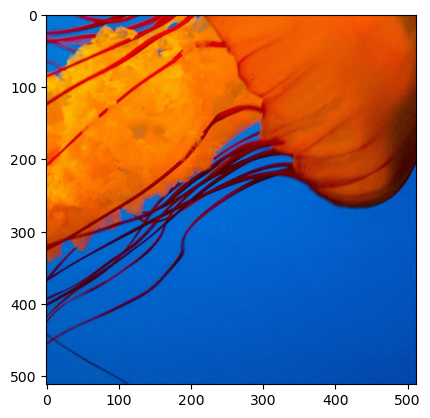

In [5]:
# load a random div2k image
#random.randint(1, 801)
n = str(48).zfill(4)
img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(512),    
    torchvision.transforms.ToTensor()
])
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))

In [6]:
# defining the model
layers = [256, 256, 256, 256, 256]
in_features = 2
out_features = 3
initializer = 'siren'
w0 = 1.0
w0_initial = 30.0
c = 6
model = SIREN(
    layers, in_features, out_features, w0, w0_initial,
    initializer=initializer, c=c)

# defining the input
x = torch.rand(10, 2)

# forward pass
y = model(x)

In [5]:
# for testing
torch.combinations(torch.arange(1,4), with_replacement=True)

tensor([[1, 1],
        [1, 2],
        [1, 3],
        [2, 2],
        [2, 3],
        [3, 3]])

In [6]:
# for testing
torch.linspace(-1.0,1.0,512, device=device).shape

torch.Size([512])

In [7]:
# for testing
x_grid, y_grid = torch.meshgrid(torch.arange(1,4),torch.arange(1,4))
torch.cat((x_grid, y_grid), dim = 2)

c:\Users\Andrew\anaconda3\envs\eecs6322-a1\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [9]:
# for testing
torch.unsqueeze(x_grid, dim=2)

tensor([[[1],
         [1],
         [1]],

        [[2],
         [2],
         [2]],

        [[3],
         [3],
         [3]]])

In [10]:
# for testing
x_grid, y_grid = torch.meshgrid(torch.arange(1,4),torch.arange(1,4))
inputs = torch.cat((torch.unsqueeze(x_grid, dim=2), torch.unsqueeze(y_grid, dim=2)), dim = 2)

In [11]:
inputs.shape

torch.Size([3, 3, 2])

In [25]:
# for testing, no good
x_in = torch.combinations(torch.linspace(-1.0,1.0,512, device=device), with_replacement=True)
x_in.shape

torch.Size([131328, 2])

In [7]:
# use as input
x_grid, y_grid = torch.meshgrid(torch.linspace(-1.0,1.0,512, device=device),torch.linspace(-1.0,1.0,512, device=device))
x_in = torch.cat((torch.unsqueeze(x_grid, dim=2), torch.unsqueeze(y_grid, dim=2)), dim = 2)

c:\Users\Andrew\anaconda3\envs\eecs6322-a1\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
x_in.shape

torch.Size([512, 512, 2])

In [9]:
model.to(device)

SIREN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Sine()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Sine()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Sine()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Sine()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Sine()
    (10): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [10]:
model(x_in).shape

torch.Size([512, 512, 3])

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()
print_step = 500
n_epochs = 20000
target = img.permute(1,2,0).to(device)
for epoch in range(n_epochs+1):
    #optimizer.zero_grad()
    for param in model.parameters():
        param.grad = None
    
    out = model(x_in)     
    #print(out.shape, img.shape)   
    loss = loss_fn(out, target)
    loss.backward()
    optimizer.step()
    
    if epoch % print_step == 0:
        print(f'Iteration: {epoch} | Loss: {loss.item()}')

Iteration: 0 | Loss: 1.2037861347198486
Iteration: 500 | Loss: 0.009676842018961906
Iteration: 1000 | Loss: 0.003956818487495184
Iteration: 1500 | Loss: 0.002409199019894004
Iteration: 2000 | Loss: 0.0017127053579315543
Iteration: 2500 | Loss: 0.0013181846588850021
Iteration: 3000 | Loss: 0.0010630678152665496
Iteration: 3500 | Loss: 0.0008834603941068053
Iteration: 4000 | Loss: 0.0007495753816328943
Iteration: 4500 | Loss: 0.0006457346607930958
Iteration: 5000 | Loss: 0.0005628640064969659
Iteration: 5500 | Loss: 0.0004954659380018711
Iteration: 6000 | Loss: 0.00044001018977724016
Iteration: 6500 | Loss: 0.0003950742247980088
Iteration: 7000 | Loss: 0.000355938624124974
Iteration: 7500 | Loss: 0.00032472453312948346
Iteration: 8000 | Loss: 0.0002993843227159232
Iteration: 8500 | Loss: 0.0002777677436824888
Iteration: 9000 | Loss: 0.0002606752677820623
Iteration: 9500 | Loss: 0.0002455536159686744
Iteration: 10000 | Loss: 0.0002330415154574439
Iteration: 10500 | Loss: 0.000224107803660

In [32]:
final = model(x_in)
print(f'PSNR: {psnr(img.permute(1,2,0), final.cpu())}')

PSNR: 38.66351318359375


In [11]:
image_nums = [383, 463, 384, 49, 421, 206, 229, 420, 583, 270, 553, 181]

In [12]:
# Try again with r = 1
#sample_factor = 10 # divide total number of pixels by sample factor
n_epochs = 20000

image_numbers = image_nums # use previous image numbers
images_trained = dict.fromkeys(image_numbers, {})

layers = [256, 256, 256, 256, 256]
in_features = 2
out_features = 3
initializer = 'siren'
w0 = 1.0
w0_initial = 30.0
c = 6


for i,image_num in enumerate(image_numbers):
    print(f"Training Image {image_num}, image {i+1}/12")
    # Get the image
    n = str(image_num).zfill(4)
    img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(512),    
        torchvision.transforms.ToTensor()
    ])
    img = transforms(img)

    model = SIREN(
    layers, in_features, out_features, w0, w0_initial,
    initializer=initializer, c=c)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = torch.nn.MSELoss()
    print_step = 500
    target = img.permute(1,2,0).to(device)


    train_time = time.time()
    for epoch in range(n_epochs+1):
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

        out = model(x_in)     
        #print(out.shape, img.shape)   
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()

        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')
    train_time = time.time() - train_time

    final = model(x_in)
    psnr_score = psnr(img.permute(1,2,0), final.cpu())

    images_trained[image_num]['psnr'] = psnr_score
    images_trained[image_num]['time'] = train_time
    images_trained[image_num]['n_epochs'] = n_epochs
    print(f'PSNR: {psnr_score} time: {train_time}')

    # Save the model
    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_SIREN_test.pth")


Training Image 383, image 1/12
Iteration: 0 | Loss: 0.9562768340110779
Iteration: 500 | Loss: 0.006360099650919437
Iteration: 1000 | Loss: 0.0024986770004034042
Iteration: 1500 | Loss: 0.0015141391195356846
Iteration: 2000 | Loss: 0.0010950594441965222
Iteration: 2500 | Loss: 0.0008704799111001194
Iteration: 3000 | Loss: 0.0007328173378482461
Iteration: 3500 | Loss: 0.0006405377062037587
Iteration: 4000 | Loss: 0.0005744534428231418
Iteration: 4500 | Loss: 0.000524519186001271
Iteration: 5000 | Loss: 0.0004849726101383567
Iteration: 5500 | Loss: 0.0004522714880295098
Iteration: 6000 | Loss: 0.00042411661706864834
Iteration: 6500 | Loss: 0.0003992788842879236
Iteration: 7000 | Loss: 0.00037722586421296
Iteration: 7500 | Loss: 0.00035738394944928586
Iteration: 8000 | Loss: 0.00033998742583207786
Iteration: 8500 | Loss: 0.000322409876389429
Iteration: 9000 | Loss: 0.0003116180596407503
Iteration: 9500 | Loss: 0.00029276186251081526
Iteration: 10000 | Loss: 0.00028419928275980055
Iteration

In [13]:
file = open('test_data_SIREN_20ktest.pkl', 'wb')
pickle.dump(images_trained, file)
file.close()

In [14]:
data = images_trained
total_time = 0
num_images = 0
sum_psnr = 0
for pic in data:
    num_images += 1
    total_time += data[pic]['time']
    sum_psnr += data[pic]['psnr']
print(f"Training time: {total_time/60.0:.2f}")
print(f"Average PSNR: {sum_psnr/num_images:.2f}")

Training time: 126.78
Average PSNR: 33.34


Get images from tests

In [9]:
# defining the model
layers = [256, 256, 256, 256, 256]
in_features = 2
out_features = 3
initializer = 'siren'
w0 = 1.0
w0_initial = 30.0
c = 6
model = SIREN(
    layers, in_features, out_features, w0, w0_initial,
    initializer=initializer, c=c)

# defining the input
x = torch.rand(10, 2)

# forward pass
y = model(x)

In [40]:
# Try again with r = 1, Removed for loop in forward
sample_factor = 10 # divide total number of pixels by sample factor
n_epochs = 20000
size = 512

x = torch.linspace(1, size, size).reshape(-1,1).to(device)
y = torch.linspace(1, size, size).reshape(-1,1).to(device)
x_grid, y_grid = torch.meshgrid(torch.linspace(-1.0,1.0, size, device=device),torch.linspace(-1.0,1.0,size, device=device))
x_in = torch.cat((torch.unsqueeze(x_grid, dim=2), torch.unsqueeze(y_grid, dim=2)), dim = 2,).to(device)

images_dir = "output_images/"

image_numbers = [383, 463, 384, 49, 421, 206, 229, 420, 583, 270, 553, 181] #image_nums # use previous image numbers
images_trained = dict.fromkeys(image_numbers, {})
for i,image_num in enumerate(image_numbers):
    print(f"Training Image {image_num}, image {i+1}/12")
    # Get the image
    n = str(image_num).zfill(4)
    img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(512),    
        torchvision.transforms.ToTensor()
    ])
    img = transforms(img)

    torchvision.utils.save_image(img, images_dir+f"ground_truth_{n}.jpg")
    
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    model.load_state_dict(torch.load(MODEL_DIR+f"image{n}_{n_epochs}epochs_R1_no_sampling_.pth"))
    model.eval()
    with torch.no_grad():
        final = model([x,y])
    
    torchvision.utils.save_image(img, images_dir+f"coordx_nosample_{n}.jpg")

    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    model.load_state_dict(torch.load(MODEL_DIR+f"image{n}_{n_epochs}epochs_R1_test_sampled.pth"))
    model.eval()
    with torch.no_grad():
        final = model([x,y])
    
    torchvision.utils.save_image(img, images_dir+f"coordx_sampled_{n}.jpg")

    model = SIREN( layers, in_features, out_features, w0, w0_initial, initializer=initializer, c=c).to(device)
    model.load_state_dict(torch.load(MODEL_DIR+f"image{n}_{n_epochs}epochs_SIREN_test.pth"))
    model.eval()
    with torch.no_grad():
        final = model(x_in.to(device))
    
    torchvision.utils.save_image(img, images_dir+f"SIREN_{n}.jpg")

    
    """
    # Test training the image without sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=1000)
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['no_sampling_psnr'] = psnr_score
    images_trained[image_num]['no_sampling_time'] = train_time
    images_trained[image_num]['n_epochs'] = n_epochs
    print(f'PSNR: {psnr_score} time: {train_time}')

    # Save the model
    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_cheatbad_no_sampling_.pth")

    #training with sampling
    model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=1, R_strat=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
    train_time = time.time()
    accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=n_epochs, print_step=1000, n_samples=int((512*512)/sample_factor))
    train_time = time.time() - train_time
    final = model([x,y])
    psnr_score = psnr(img, final.cpu())
    images_trained[image_num]['sampled_psnr'] = psnr_score
    images_trained[image_num]['sampled_time'] = train_time
    print(f'PSNR: {psnr_score} time: {train_time}')

    torch.save(model.state_dict(), MODEL_DIR+f"image{n}_{n_epochs}epochs_cheatbad_test_sampled.pth")
    """


Training Image 383, image 1/12
Training Image 463, image 2/12
Training Image 384, image 3/12
Training Image 49, image 4/12
Training Image 421, image 5/12
Training Image 206, image 6/12
Training Image 229, image 7/12
Training Image 420, image 8/12
Training Image 583, image 9/12
Training Image 270, image 10/12
Training Image 553, image 11/12
Training Image 181, image 12/12
